# Алешко Альберт Вариант 1 
# Задание 3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr
import pingouin as pg
import tqdm
from statsmodels.formula.api import ols
plt.style.use('Solarize_Light2') # Функция для задания стиля графикам

In [2]:
sheet_name = '2-1'
# sheet_name = '1вар-адекв'
data = pd.read_excel('data2.xlsx', sheet_name=sheet_name, 
                     header=None, names=['var1', 'var2', 'var3', 'var4', 'var5']) # читаем из файла все выборки 
# data# выводим их

In [3]:
length = len(data.T)

In [4]:
def get_correlation(df, corr_func):
    names = df.columns
    correlation = np.zeros((length, length))
    correlation[range(length), range(length)] = 1
    p_values = np.zeros((length, length))
    p_values[range(length), range(length)] = 1

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            res = corr_func(df[names[i]], df[names[j]])
            correlation[i, j] = correlation[j, i] = res[0]
            p_values[i, j] = p_values[j, i] = res[1]
    df_correlation = pd.DataFrame(correlation)
    df_p_values = pd.DataFrame(p_values)
    df_correlation.columns = df_p_values.columns = names
    df_correlation.index = df_p_values.index = names
    
    return df_correlation, df_p_values

In [5]:
corr, p_vals = get_correlation(data, pearsonr)

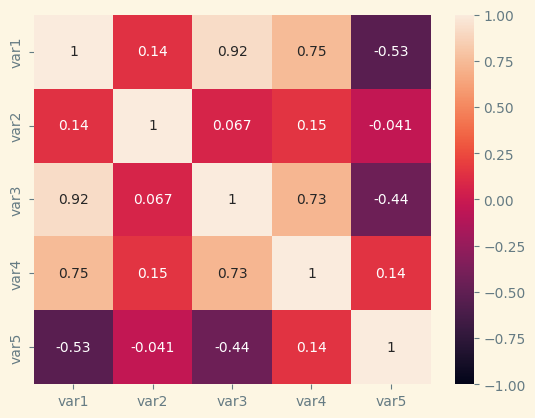

In [6]:
sns.heatmap(corr, annot=True, vmin=-1, vmax=1);

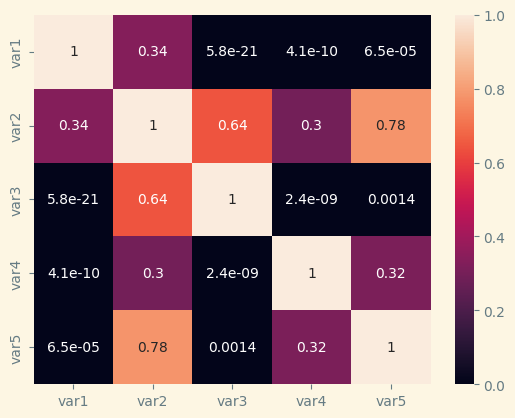

In [7]:
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1);

In [8]:
def get_part_corr(df):
    names = df.columns
    correlation = np.zeros((length, length))
    correlation[range(length), range(length)] = 1
    p_values = np.zeros((length, length))
    p_values[range(length), range(length)] = 1

    for i in range(len(names)):
        for j in range(i+1, len(names)):
            co_names = list(df.columns)
            co_names.remove(names[i])
            if names[j] in co_names:
                co_names.remove(names[j])
            # print((names[i],names[j]),co_names)
            res = pg.partial_corr(data=df, x=names[i], y=names[j], covar=co_names)
            correlation[i, j] = correlation[j, i] = res['r'].iloc[0]
            p_values[i, j] = p_values[j, i] = res['p-val'].iloc[0]
    df_correlation = pd.DataFrame(correlation)
    df_p_values = pd.DataFrame(p_values)
    df_correlation.columns = df_p_values.columns = names
    df_correlation.index = df_p_values.index = names
    
    return df_correlation, df_p_values

In [9]:
# partial_corr = pg.partial_corr(data=data, x='1', y='2', covar=['3','4','5'])
corr_part, p_vals = get_part_corr(data)
# print(partial_corr)

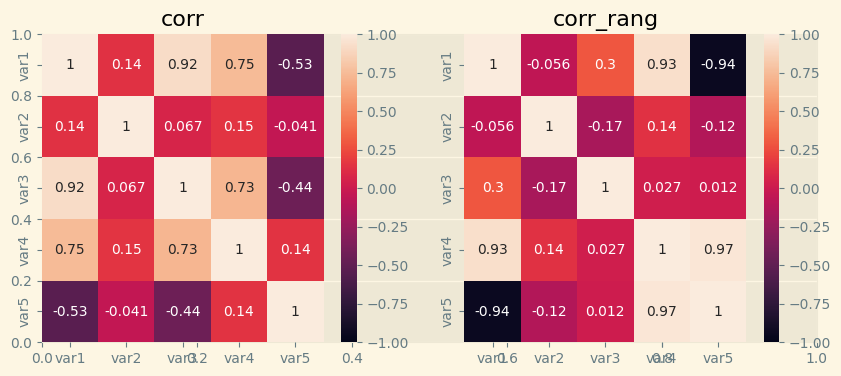

In [10]:
fig = plt.subplots(figsize=(10, 4))

plt.subplot(121)
plt.title('corr')
sns.heatmap(corr, annot=True, vmin=-1, vmax=1);

plt.subplot(122)
plt.title('corr_rang')
sns.heatmap(corr_part, annot=True, vmin=-1, vmax=1);

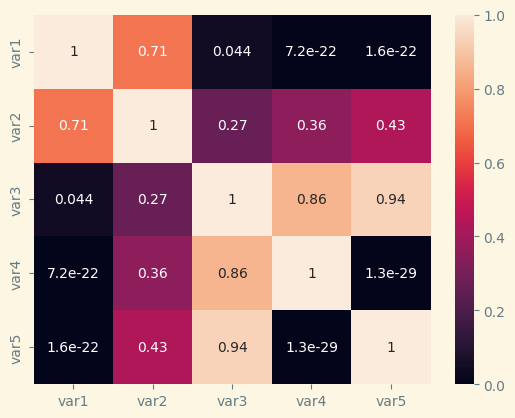

In [11]:
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1);

In [12]:
def multiple_correlation(df):
    names = df.columns
    length = len(names)
    correlation = np.zeros((length))
    p_values = np.zeros((length))
    
    for i, name in enumerate(names):
        formula = name + ' ~ ' + ' + '.join([n for j, n in enumerate(names) if j != i])
        mod = ols(formula=formula, data=df)
        res = mod.fit()
        correlation[i] = res.rsquared ** 0.5
        p_values[i] = res.f_pvalue
    
    return correlation, p_values

In [13]:
multi_corr, p_vals = multiple_correlation(data)

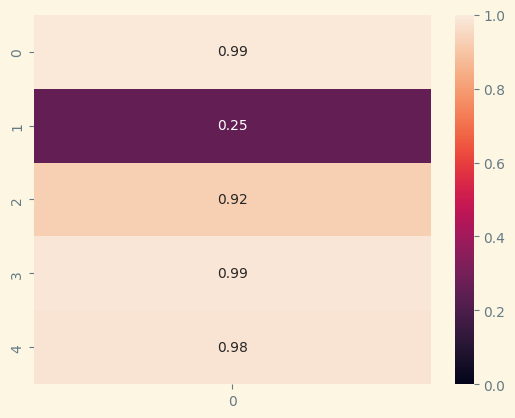

In [14]:
sns.heatmap(multi_corr[..., None], annot=True, vmin=0, vmax=1);

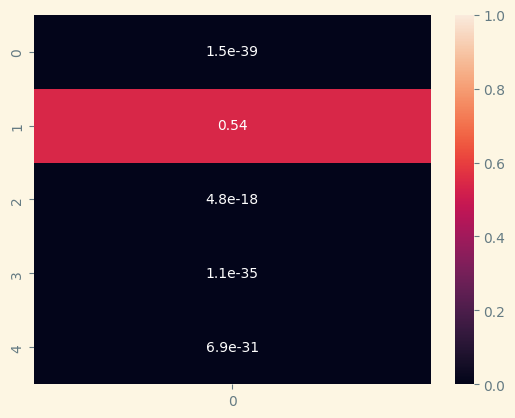

In [15]:
sns.heatmap(p_vals[..., None], annot=True, vmin=0, vmax=1);

In [16]:
corr_rang, p_vals = get_correlation(data, spearmanr)

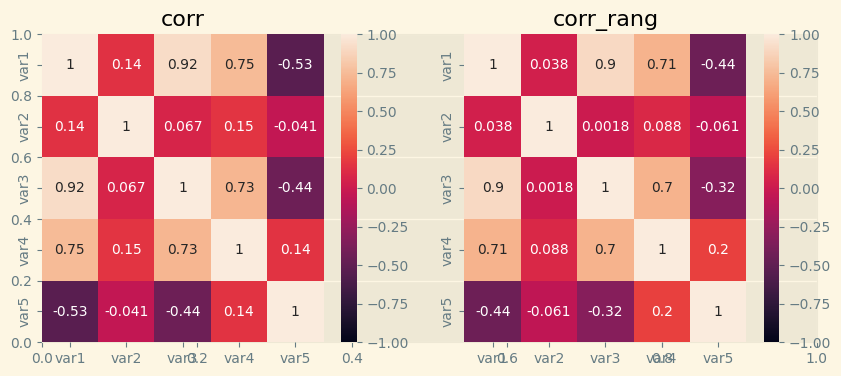

In [17]:
fig = plt.subplots(figsize=(10, 4))

plt.subplot(121)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1);
plt.title('corr')

plt.subplot(122)
plt.title('corr_rang')
sns.heatmap(corr_rang, annot=True, vmin=-1, vmax=1);

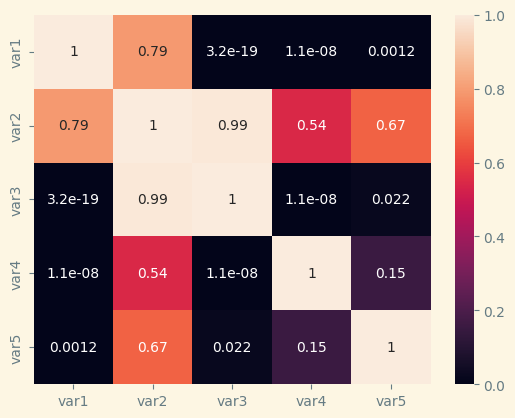

In [18]:
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1);

In [19]:
from math import *
import scipy as sci

In [20]:
def Cheddock_scale_check(r, name='r'):
    # задаем шкалу Чеддока
        # no correlation (n <= 0.1)'
        # very weak (0.1 < n <= 0.2)'
        # weak (0.2 < n <= 0.3)'
        # moderate (0.3 < n <= 0.5)'
        # perceptible (0.5 < n <= 0.7)'
        # high (0.7 < n <= 0.9)'
        # very high (0.9 < n <= 0.99)'
        # functional (n > 0.99)'
    Cheddock_scale = {
        f'no correlation':    0.1,
        f'very weak':   0.2,
        f'weak ':        0.3,
        f'moderate':    0.5,
        f'perceptible': 0.7,
        f'high':        0.9,
        f'very high':  0.99,
        f'functional':        1.0}
    
    r_scale = list(Cheddock_scale.values())
    for i, elem in enumerate(r_scale):
        if abs(r) <= elem:
            conclusion_Cheddock_scale = list(Cheddock_scale.keys())[i]
            break
    return conclusion_Cheddock_scale

In [21]:
def corr_ratio_check(X, Y, p_level=0.95, orientation='XY', scale='Cheddok'):
    a_level = 1 - p_level
    name = f'{X.name} {Y.name}'
    X = np.array(X)
    Y = np.array(Y)
    n_X = len(X)
    n_Y = len(Y)    
    # запишем данные в DataFrame
    matrix_XY_df = pd.DataFrame({
        'X': X,
        'Y': Y})
    # число интервалов группировки
    group_int_number = lambda n: round (3.31*log(n_X, 10)+1) if round (3.31*log(n_X, 10)+1) >=2 else 2
    K_X = group_int_number(n_X)
    K_Y = group_int_number(n_Y)
    # группировка данных и формирование корреляционной таблицы
    cut_X = pd.cut(X, bins=K_X)
    cut_Y = pd.cut(Y, bins=K_Y)
    matrix_XY_df['cut_X'] = cut_X
    matrix_XY_df['cut_Y'] = cut_Y
    CorrTable_df = pd.crosstab(
        index=matrix_XY_df['cut_X'],
        columns=matrix_XY_df['cut_Y'],
        rownames=['cut_X'],
        colnames=['cut_Y'])
    CorrTable_np = np.array(CorrTable_df)
    K_X = len(CorrTable_np)
    K_Y = len(CorrTable_np[0])
    # итоги корреляционной таблицы по строкам и столбцам
    n_group_X = [np.sum(CorrTable_np[i]) for i in range(K_X)]
    n_group_Y = [np.sum(CorrTable_np[:,j]) for j in range(len(CorrTable_np[0]))]
    # среднегрупповые значения переменной X
    Xboun_mean = [(CorrTable_df.index[i].left + CorrTable_df.index[i].right)/2 for i in range(K_X)]
    Xboun_mean[0] = (np.min(X) + CorrTable_df.index[0].right)/2    # исправляем значения в крайних интервалах
    Xboun_mean[K_X-1] = (CorrTable_df.index[K_X-1].left + np.max(X))/2
    # среднегрупповые значения переменной Y
    Yboun_mean = [(CorrTable_df.columns[j].left + CorrTable_df.columns[j].right)/2 for j in range(K_Y)]
    Yboun_mean[0] = (np.min(Y) + CorrTable_df.columns[0].right)/2    # исправляем значения в крайних интервалах
    Yboun_mean[K_Y-1] = (CorrTable_df.columns[K_Y-1].left + np.max(Y))/2
    # средневзевешенные значения X и Y для каждой группы
    Xmean_group = [np.sum(CorrTable_np[:,j] * Xboun_mean) / n_group_Y[j] for j in range(K_Y)]
    Ymean_group = [np.sum(CorrTable_np[i] * Yboun_mean) / n_group_X[i] for i in range(K_X)]
    # общая дисперсия X и Y
    Sum2_total_X = np.sum(n_group_X * (Xboun_mean - np.mean(X))**2)
    Sum2_total_Y = np.sum(n_group_Y * (Yboun_mean - np.mean(Y))**2)
    # межгрупповая дисперсия X и Y (дисперсия групповых средних)
    Sum2_between_group_X = np.sum(n_group_Y * (Xmean_group - np.mean(X))**2)
    Sum2_between_group_Y = np.sum(n_group_X * (Ymean_group - np.mean(Y))**2)
    # эмпирическое корреляционное отношение
    corr_ratio_XY = sqrt(Sum2_between_group_Y / Sum2_total_Y)
    corr_ratio_YX = sqrt(Sum2_between_group_X / Sum2_total_X)
    try:
        if orientation!='XY' and orientation!='YX':
            raise ValueError("Error! Incorrect orientation!")
        if orientation=='XY':
            corr_ratio = corr_ratio_XY
        elif orientation=='YX':
            corr_ratio = corr_ratio_YX
    except ValueError as err:
        print(err)
    # проверка гипотезы о значимости корреляционного отношения
    F_corr_ratio_calc = (n_X - K_X)/(K_X - 1) * corr_ratio**2 / (1 - corr_ratio**2)
    dfn = K_X - 1
    dfd = n_X - K_X
    F_corr_ratio_table = sci.stats.f.ppf(p_level, dfn, dfd, loc=0, scale=1)
    a_corr_ratio_calc = 1 - sci.stats.f.cdf(F_corr_ratio_calc, dfn, dfd, loc=0, scale=1)
    conclusion_corr_ratio_sign = 'significance' if F_corr_ratio_calc >= F_corr_ratio_table else 'not significance'
    # доверительный интервал корреляционного отношения
    if F_corr_ratio_calc >= F_corr_ratio_table:
        f1 = round ((K_X - 1 + n_X * corr_ratio**2)**2 / (K_X - 1 + 2 * n_X * corr_ratio**2))
        f2 = n_X - K_X
        z1 = (n_X - K_X) / n_X * corr_ratio**2 / (1 - corr_ratio**2) * 1/sci.stats.f.ppf(p_level, f1, f2, loc=0, scale=1) - (K_X - 1)/n_X
        z2 = (n_X - K_X) / n_X * corr_ratio**2 / (1 - corr_ratio**2) * 1/sci.stats.f.ppf(1 - p_level, f1, f2, loc=0, scale=1) - (K_X - 1)/n_X
        corr_ratio_conf_int_low = sqrt(z1) if sqrt(z1) >= 0 else 0
        corr_ratio_conf_int_high = sqrt(z2) if sqrt(z2) <= 1 else 1
    else:
        corr_ratio_conf_int_low = corr_ratio_conf_int_high = '-'    
    # оценка тесноты связи
    if scale=='Cheddok':
        conclusion_corr_ratio_scale = scale + ': ' + Cheddock_scale_check(corr_ratio, name=chr(951))
    elif scale=='Evans':
        conclusion_corr_ratio_scale = scale + ': ' + Evans_scale_check(corr_ratio, name=chr(951))
    # формируем результат            
    result = pd.DataFrame({
        'notation': (chr(951)),
        'coef_value': (corr_ratio),
        'c_v_squared': (corr_ratio**2),
        'p_level': (p_level),
        'a_level': (a_level),
        'F_calc': (F_corr_ratio_calc),
        'F_table': (F_corr_ratio_table),
        'F_calc >= F_table': (F_corr_ratio_calc >= F_corr_ratio_table),
        'a_calc': (a_corr_ratio_calc),
        'a_calc <= a_level': (a_corr_ratio_calc <= a_level),
        'significance': (conclusion_corr_ratio_sign),
        'conf_int_low': (corr_ratio_conf_int_low),
        'conf_int_high': (corr_ratio_conf_int_high),
        'scale': (conclusion_corr_ratio_scale)
        },
        index=[name])
    
    return result      

In [22]:
names = data.columns
new_df = pd.DataFrame({
        'notation': (),
        'coef_value': (),
        'c_v_squared': (),
        'p_level': (),
        'a_level': (),
        'F_calc': (),
        'F_table': (),
        'F_calc >= F_table': (),
        'a_calc': (),
        'a_calc <= a_level': (),
        'significance': (),
        'conf_int_low': (),
        'conf_int_high': (),
        'scale': ()
        })
for one in names:
    for two in names:
        if(one!=two):
            try:
                res = corr_ratio_check(data[one], data[two])
                new_df = pd.concat([new_df, res])
            except:
                print('error')

In [23]:
new_df

,notation,coef_value,c_v_squared,p_level,a_level,F_calc,F_table,F_calc >= F_table,a_calc,a_calc <= a_level,significance,conf_int_low,conf_int_high,scale
var1 var2,η,0.406018,0.164851,0.95,0.05,1.414632,2.318498,0.0,2.311710e-01,0.0,not significance,-,-,Cheddok: moderate
var1 var3,η,0.920520,0.847357,0.95,0.05,39.783996,2.318498,True,5.551115e-16,True,significance,1.612586,1,Cheddok: very high
var1 var4,η,0.702272,0.493185,0.95,0.05,6.973938,2.318498,True,3.177223e-05,True,significance,0.57308,1,Cheddok: high
var1 var5,η,0.618713,0.382805,0.95,0.05,4.445013,2.318498,True,1.393598e-03,True,significance,0.395595,1,Cheddok: perceptible
var2 var1,η,0.404477,0.163602,0.95,0.05,1.401822,2.318498,False,2.360105e-01,False,not significance,-,-,Cheddok: moderate
var2 var3,η,0.476072,0.226645,0.95,0.05,2.100309,2.318498,False,7.286889e-02,False,not significance,-,-,Cheddok: moderate
var2 var4,η,0.481702,0.232037,0.95,0.05,2.165375,2.318498,False,6.513877e-02,False,not significance,-,-,Cheddok: moderate
var2 var5,η,0.272468,0.074239,0.95,0.05,0.574711,2.318498,False,7.482250e-01,False,not significance,-,-,Cheddok: weak
var3 var1,η,0.909746,0.827638,0.95,0.05,34.412455,2.318498,True,7.105427e-15,True,significance,1.490374,1,Cheddok: very high
var3 var2,η,0.336767,0.113412,0.95,0.05,0.916756,2.318498,False,4.922925e-01,False,not significance,-,-,Cheddok: moderate
